In [1]:
import brainpy.math as bm
import numpy as np
from PCCAN_utils import get_tuningMap, animate_sweeps
from models import PC_cell

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

## Section 1: generate behavioral running trajectories in open fields using RatInABox

/tmp/ipykernel_3459122/1916401667.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue


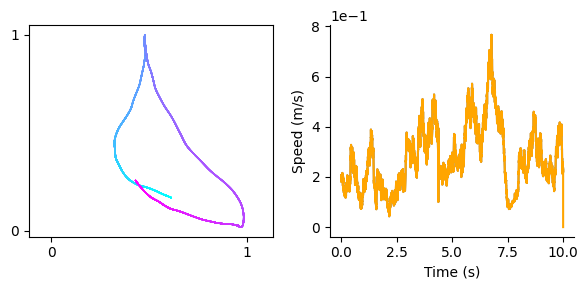

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 10 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rotation_velocity_std = 60 * (np.pi / 180) #in rad/s

Ag = Agent(Env, params = {
    "dt": dt,
    "speed_mean":speed_mean,
    "speed_std": speed_std,
    "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
    })

while Ag.t < dur:
    Ag.update(drift_velocity=None)

Position = Ag.history['pos']
Position = np.array(Position)
# Position_2_2pi = Position*(2*np.pi)-np.pi
Vel = Ag.history['vel']
Speed = np.linalg.norm(Vel, axis=1) / 1000 # meters per ms

diff = np.diff(Position, axis=0)
Vel2 = np.zeros_like(Position)
Vel2[:-1,:] = diff
Speed2 = np.linalg.norm(Vel2, axis=1)

#visualize the trajectory
fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
# ax.plot(Position[:,1], Position[:,0], linewidth=0.5, color='black')
# ax.axis('equal')
# ax.set_xticks([])
# ax.set_yticks([])
# #invert_yaxis

# Set up a colour map from green to blue
cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue

# Plot each segment with a different colour
for i in range(len(Position) - 1):
    ax.plot(
        [Position[i, 0], Position[i + 1, 0]], 
        [Position[i, 1], Position[i + 1, 1]], 
        color=cmap(i / len(Position)), 
        linewidth=1
    )
ax.axis('equal')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
# ax.invert_yaxis()

ax = axs[1]
ax.plot(np.arange(0, dur+dt, dt), Speed*1000, label='speed', color='grey')
ax.plot(np.arange(0, dur+dt, dt), Speed2*1000, label='speed2', color='orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Time (s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

## Section 2: Simulate place cell network with homogeneous synaptic weights 

In [28]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0)

#hyperparameters
m0 = 15 #adaptation strength
z_min = 0; z_max = 1 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 0.5 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 100 #number of PC cells on x or y axis

bm.clear_buffer_memory(platform='gpu')

#build the network
PC_net = PC_cell(num=num, tau=10, tauv=100, m0=m0, k=1, a=0.08, A=10.0, J0=4.0, z_min=z_min, z_max=z_max)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter

time_steps = np.arange(duration+1)
print('Running simulation...')
pc_activity, pc_bumpcenter = bm.for_loop(runNet, (time_steps, Position, Speed))

#animate the sweeps and save the animation
print('Animating...')
save_path = './animations/'
filename_prefix = 'Plain_adaptation_'
animate_sweeps(Position, pc_activity, num, duration, Speed, m0, n_step=10, goal_loc=None, save_path=save_path, filename_prefix=filename_prefix)


Running simulation...


Animating...


MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved to ./animations/Plain_adaptation_15.gif


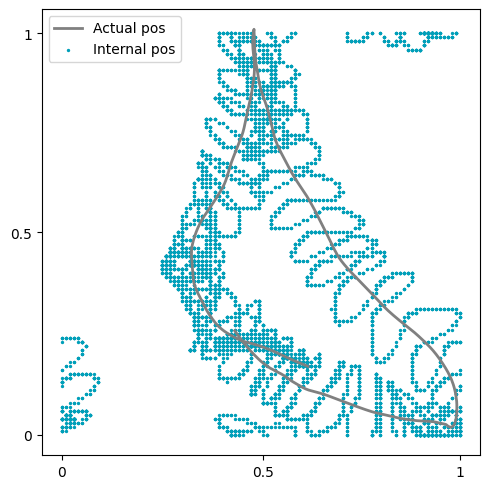

In [29]:
fig, ax  = plt.subplots(1, 1, figsize=(5,5), dpi=100)
# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')
ax.scatter(pc_bumpcenter[:, 0], pc_bumpcenter[:, 1], color='#009FB9', s=2, label='Internal pos')

ax.set_xticks([0, 50, 99])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, 50, 99])
ax.set_yticklabels([0, 0.5, 1])
ax.legend()

plt.tight_layout()
plt.savefig('./figures/Plain_sweeptraj.pdf', dpi=300)

## Section 3: Simulate place cell network with inhomogeneous synaptic connection

In [25]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0)

#hyperparameters
m0 = 15 #adaptation strength
z_min = 0; z_max = 1 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 2.0 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 100 #number of PC cells on x or y axis
goal_loc = [0.25, 0.25]

bm.clear_buffer_memory(platform='gpu')

#build the network
PC_net = PC_cell(num=num, tau=10, tauv=100, m0=m0, k=1, a=0.08, A=10.0, J0=4.0, z_min=z_min, z_max=z_max, 
                 goal_loc=goal_loc,
                 goal_J0=2,
                 goal_a=0.1)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumpcenter = PC_net.center
    return pc_activity, pc_bumpcenter

time_steps = np.arange(duration+1)
print('Running simulation...')
pc_activity, pc_bumpcenter= bm.for_loop(runNet, (time_steps, Position, Speed))

#animate the sweeps and save the animation
print('Animating...')
save_path = './animations/'
filename_prefix = 'Goal_adaptation_'
animate_sweeps(Position, pc_activity, num, duration, Speed, m0, n_step=10, goal_loc=goal_loc, save_path=save_path, filename_prefix=filename_prefix)

Running simulation...
Animating...


MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved to ./animations/Goal_adaptation_15.gif


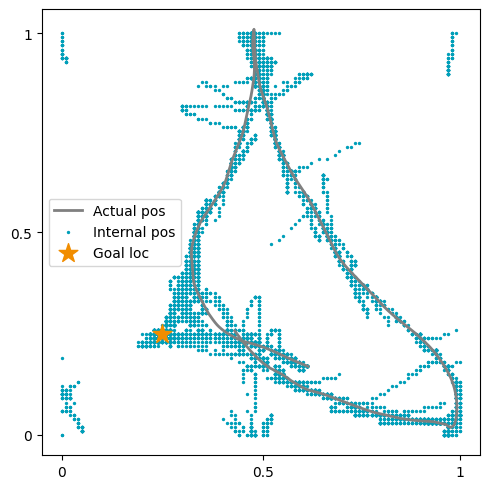

In [27]:
fig, ax  = plt.subplots(1, 1, figsize=(5,5), dpi=100)
# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')
ax.scatter(pc_bumpcenter[:, 0], pc_bumpcenter[:, 1], color='#009FB9', s=2, label='Internal pos')
ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='#F18D00', marker='*', s=200, label='Goal loc')

ax.set_xticks([0, 50, 99])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, 50, 99])
ax.set_yticklabels([0, 0.5, 1])
ax.legend()

plt.tight_layout()
plt.savefig('./figures/GD_sweeptraj.pdf', dpi=300)


#### time consuming plot but looks nicer...

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


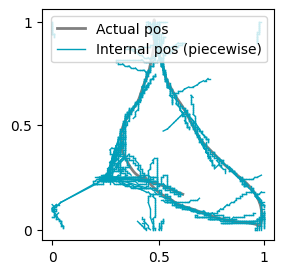

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# Plot the continuous trajectory for Position
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')

# Threshold for distance
threshold = 20

# Collect segments that meet the threshold condition
x_segments = []
y_segments = []
for i in range(len(pc_bumpcenter) - 1):
    # Calculate the Euclidean distance between consecutive points
    dist = np.sqrt((pc_bumpcenter[i+1, 0] - pc_bumpcenter[i, 0])**2 + (pc_bumpcenter[i+1, 1] - pc_bumpcenter[i, 1])**2)
    
    # If distance is below threshold, add segment to list
    if dist < threshold:
        x_segments.append([pc_bumpcenter[i, 0], pc_bumpcenter[i+1, 0]])
        y_segments.append([pc_bumpcenter[i, 1], pc_bumpcenter[i+1, 1]])

# Plot all segments at once
for x_seg, y_seg in zip(x_segments, y_segments):
    ax.plot(x_seg, y_seg, color='#009FB9', linewidth=1)

# Set fixed ticks and labels
ax.set_xticks([0, 50, 99])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, 50, 99])
ax.set_yticklabels([0, 0.5, 1])

# Add legend
ax.legend(['Actual pos', 'Internal pos'])


## Section 2: Get the firing field of several place cells

#### prepare the data 

In [4]:
activity = runner.mon.r.reshape((-1, dim, dim))*100
data = np.load('./traces/TwoDtrajectory_dur3600_speedMean0.05.npz')
positions = data['Position'][:duration*samples_per_sec,:]

#### show exampled the animal's trajectory, firing rate map for one cell and the mean map

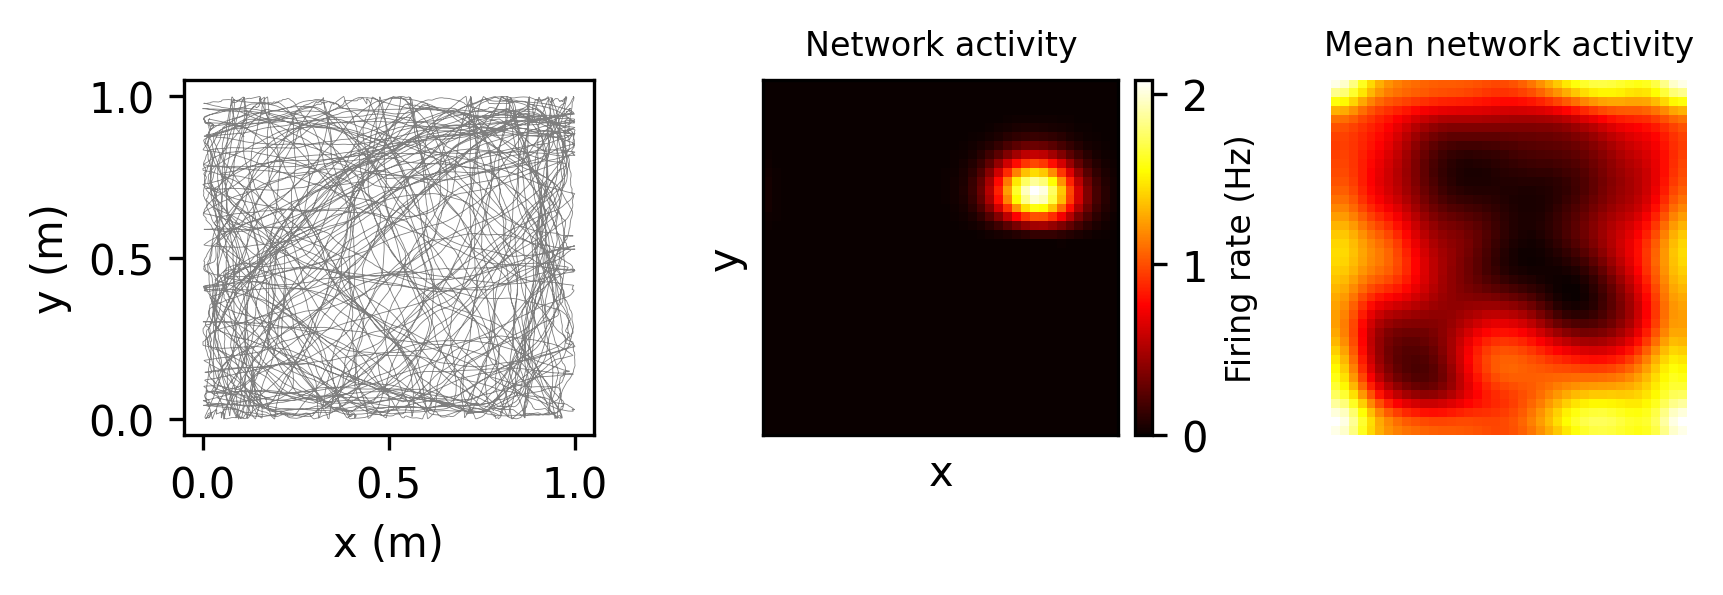

In [20]:
#plot all the firing rates in a single merged image
fig, axs = plt.subplots(1,3, figsize=(6,2), dpi=300)

ind=6000

#plot the trajectory
axs[0].plot(positions[:,0], positions[:,1], color='black', linewidth=0.2, alpha=0.5)
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')


axs[1].imshow(activity[ind,:,:], cmap='hot')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Network activity', fontsize=8)
cbar = plt.colorbar(axs[1].imshow(activity[ind,:,:], cmap='hot'), ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Firing rate (Hz)', fontsize=8)

axs[2].imshow(activity.mean(axis=0), cmap='hot')
axs[2].axis('off')
axs[2].set_title('Mean network activity', fontsize=8)


plt.tight_layout()

plt.savefig('./figures/meanactivitymap.png', dpi=300)

#### show the firing curves of several exampled cells 

Text(0.06, 0.5, 'Cell ids')

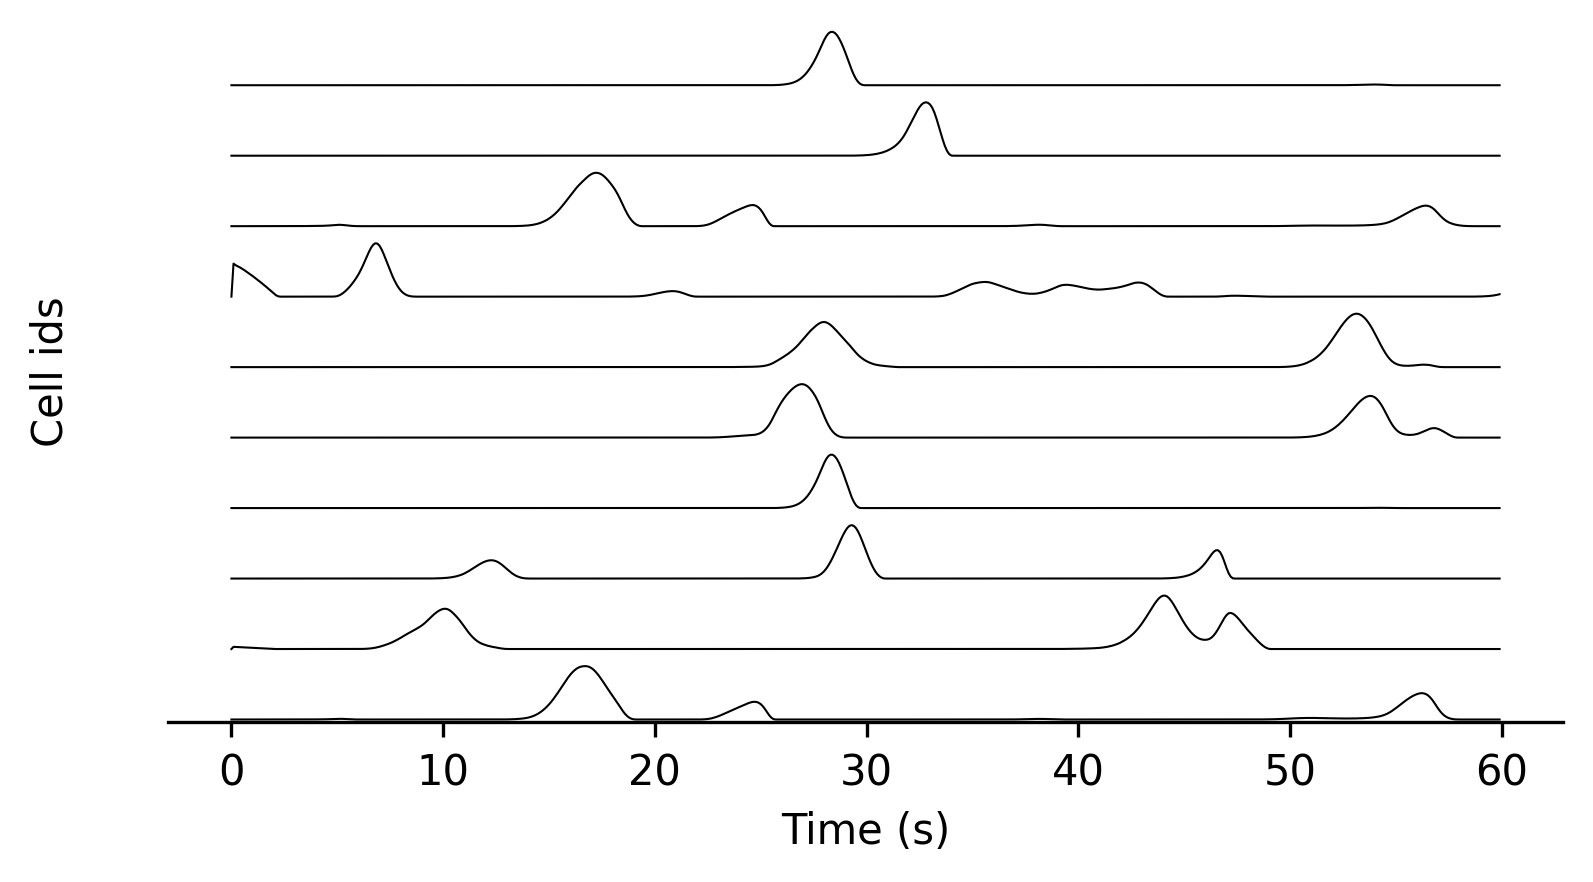

In [5]:
cellindex_x = dim//2; cellindex_y = dim//2
firing_curve = activity[:, cellindex_x, cellindex_y]

Nsamples = 10
dur = 60 #duration of visualisation in seconds
#random sampling 10 positions in between 10-20 indexes alomng two dimensions
cellindex_x = np.random.randint(5, 35, Nsamples)
cellindex_y = np.random.randint(5, 35, Nsamples)

#plot Nsamples firing curves
fig, axs = plt.subplots(Nsamples, 1, figsize=(6, 3), dpi=300)

for i in range(Nsamples):
    ind_x = cellindex_x[i]
    ind_y = cellindex_y[i]
    firing_curve = activity[:dur*samples_per_sec, ind_x, ind_y]
    axs[i].plot(np.arange(0,dur,1/samples_per_sec), firing_curve, color='black', linewidth=0.5)
    if i<Nsamples-1:
        axs[i].axis('off')
    else:
        axs[i].set_xlabel('Time (s)')
        #top and right and left spines are removed
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        #y axis is removed
        axs[i].yaxis.set_visible(False)

#add an overall xlabel and y label

fig.text(0.06, 0.5, 'Cell ids', ha='center', va='center', rotation='vertical')

#### exmaple code of finding the patches

In [6]:
from TwoDCANN_utils import find_patches
# Example array
array = np.array([[1, 0, 0, 1, 1],
                  [0, 1, 1, 1, 0],
                  [0, 1, 1, 1, 0],
                  [0, 0, 0, 0, 1]])

# Find patches
patches = find_patches(array)

# Print patches
for idx, patch in enumerate(patches, 1):
    print(f"Patch {idx}:\n{np.array([[1 if (i, j) in patch else 0 for j in range(array.shape[1])] for i in range(array.shape[0])])}\n")


Patch 1:
[[0 0 0 1 1]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]

Patch 2:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]

Patch 3:
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]



#### get the tuning map and map criteria of simulated cells with activity shift (both negative and positive)

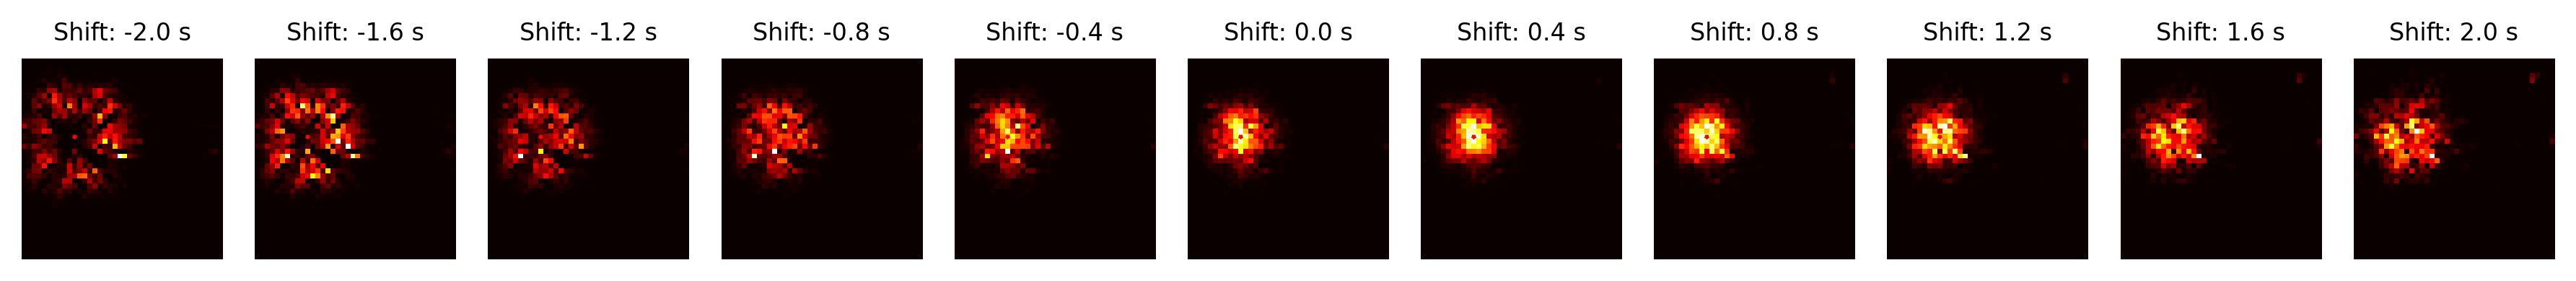

In [7]:
cellindex_x = 10; cellindex_y = 15
shifts = np.arange(-20, 24, 4)

fig, axs = plt.subplots(1, len(shifts), figsize=(12, 3), dpi=300)

for id, shift in enumerate(shifts):
    tuning_map, map_criteria = get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
    
    #plot
    axs[id].imshow(tuning_map, cmap='hot')
    axs[id].set_xlabel('x')
    axs[id].set_ylabel('y')
    #ticks from 0-1
    axs[id].set_xticks([0, 20, 40])
    axs[id].set_yticks([0, 20, 40])
    axs[id].set_xticklabels([0, 0.5, 1])
    axs[id].set_yticklabels([0, 0.5, 1])
    axs[id].set_title(f'Shift: {shift/10} s', fontsize=8)
    axs[id].axis('off')
    #add (cellindex_x, cellindex_y) as a marker on the map
    axs[id].plot(cellindex_x, cellindex_y, color='red', marker='*', markersize=1)

plt.tight_layout()
plt.savefig('./figures/tuning_map_shifts.png', dpi=300)

### an example cell's map criteria with activity shift

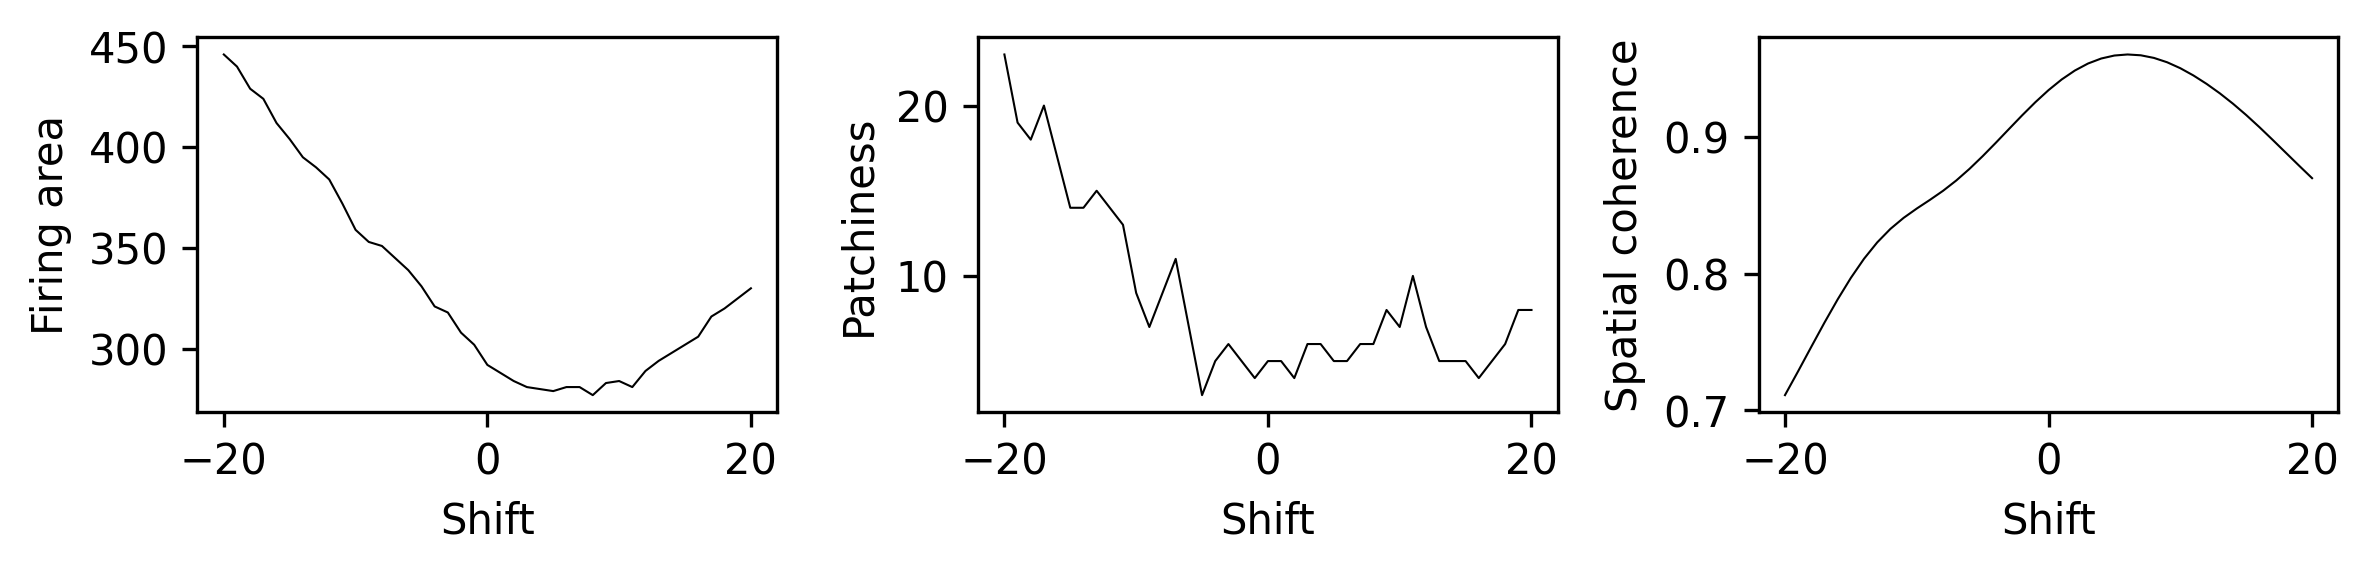

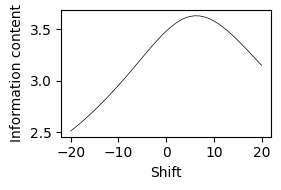

In [21]:
cellindex_x = 20; cellindex_y = 20
shifts = np.arange(-20, 21, 1)

Shift_Firing_Area = []
Patchiness = []
Spatial_Coherence = []
Spatial_Information_Content = []
for id, shift in enumerate(shifts):
    tuning_map, map_criteria = get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
    
    Shift_Firing_Area = np.append(Shift_Firing_Area, map_criteria['firing_area'])
    Patchiness = np.append(Patchiness, map_criteria['patchiness'])
    Spatial_Coherence = np.append(Spatial_Coherence, map_criteria['spatial_coherence'])
    Spatial_Information_Content = np.append(Spatial_Information_Content, map_criteria['spatial_information_content'])

fig, axs = plt.subplots(1, 3, figsize=(8, 2), dpi=300)
#plot the firing area as a function of the shift
axs[0].plot(shifts, Shift_Firing_Area, color='black', linewidth=0.5)
axs[0].set_xlabel('Shift')
axs[0].set_ylabel('Firing area')

#plot the patchiness as a function of the shift
axs[1].plot(shifts, Patchiness, color='black', linewidth=0.5)
axs[1].set_xlabel('Shift')
axs[1].set_ylabel('Patchiness')

#plot the spatial coherence as a function of the shift
axs[2].plot(shifts, Spatial_Coherence, color='black', linewidth=0.5)
axs[2].set_xlabel('Shift')
axs[2].set_ylabel('Spatial coherence')

plt.tight_layout()

plt.savefig('./figures/shift_analysis_4_examplecell.png', dpi=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
#plot the spatial information content as a function of the shift
ax.plot(shifts, Spatial_Information_Content, color='black', linewidth=0.5)
ax.set_xlabel('Shift')
ax.set_ylabel('Information content')
plt.tight_layout()
plt.savefig('./figures/spatial_information_content_4_examplecell.png')

#### many cells' map criteria with activity shift

In [22]:
#preparing the data
activity = runner.mon.r.reshape((-1, dim, dim))*100
data = np.load('./traces/TwoDtrajectory_dur3600_speedMean0.05.npz')
positions = data['Position'][:duration*samples_per_sec,:]

Nsamples = 100
#random sampling 10 positions in between 10-20 indexes alomng two dimensions
cellindex_x = np.random.randint(5, 35, Nsamples)
cellindex_y = np.random.randint(5, 35, Nsamples)

#for each cell, calculate the shift map
Shift_Firing_Area_4_all_cells = []
Patchiness_for_all_cells = []
Spatial_Coherence_for_all_cells = []
Spatial_Information_Content_for_all_cells = []

for i in range(Nsamples):
    ind_x = cellindex_x[i]
    ind_y = cellindex_y[i]
    
    shifts = np.arange(-30, 31, 1)
    Shift_Firing_Area_4_cell = []
    Patchiness_4_cell = []
    Spatial_Coherence_4_cell = []
    Spatial_Information_Content_4_cell = []
    for id, shift in enumerate(shifts):
        tuning_map, map_criteria = get_tuningMap(activity, positions, ind_x, ind_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
        Shift_Firing_Area_4_cell = np.append(Shift_Firing_Area_4_cell, map_criteria['firing_area'])
        Patchiness_4_cell = np.append(Patchiness_4_cell, map_criteria['patchiness'])
        Spatial_Coherence_4_cell = np.append(Spatial_Coherence_4_cell, map_criteria['spatial_coherence'])
        Spatial_Information_Content_4_cell = np.append(Spatial_Information_Content_4_cell, map_criteria['spatial_information_content'])
        
    Shift_Firing_Area_4_all_cells.append(Shift_Firing_Area_4_cell)
    Patchiness_for_all_cells.append(Patchiness_4_cell)
    Spatial_Coherence_for_all_cells.append(Spatial_Coherence_4_cell)
    Spatial_Information_Content_for_all_cells.append(Spatial_Information_Content_4_cell)

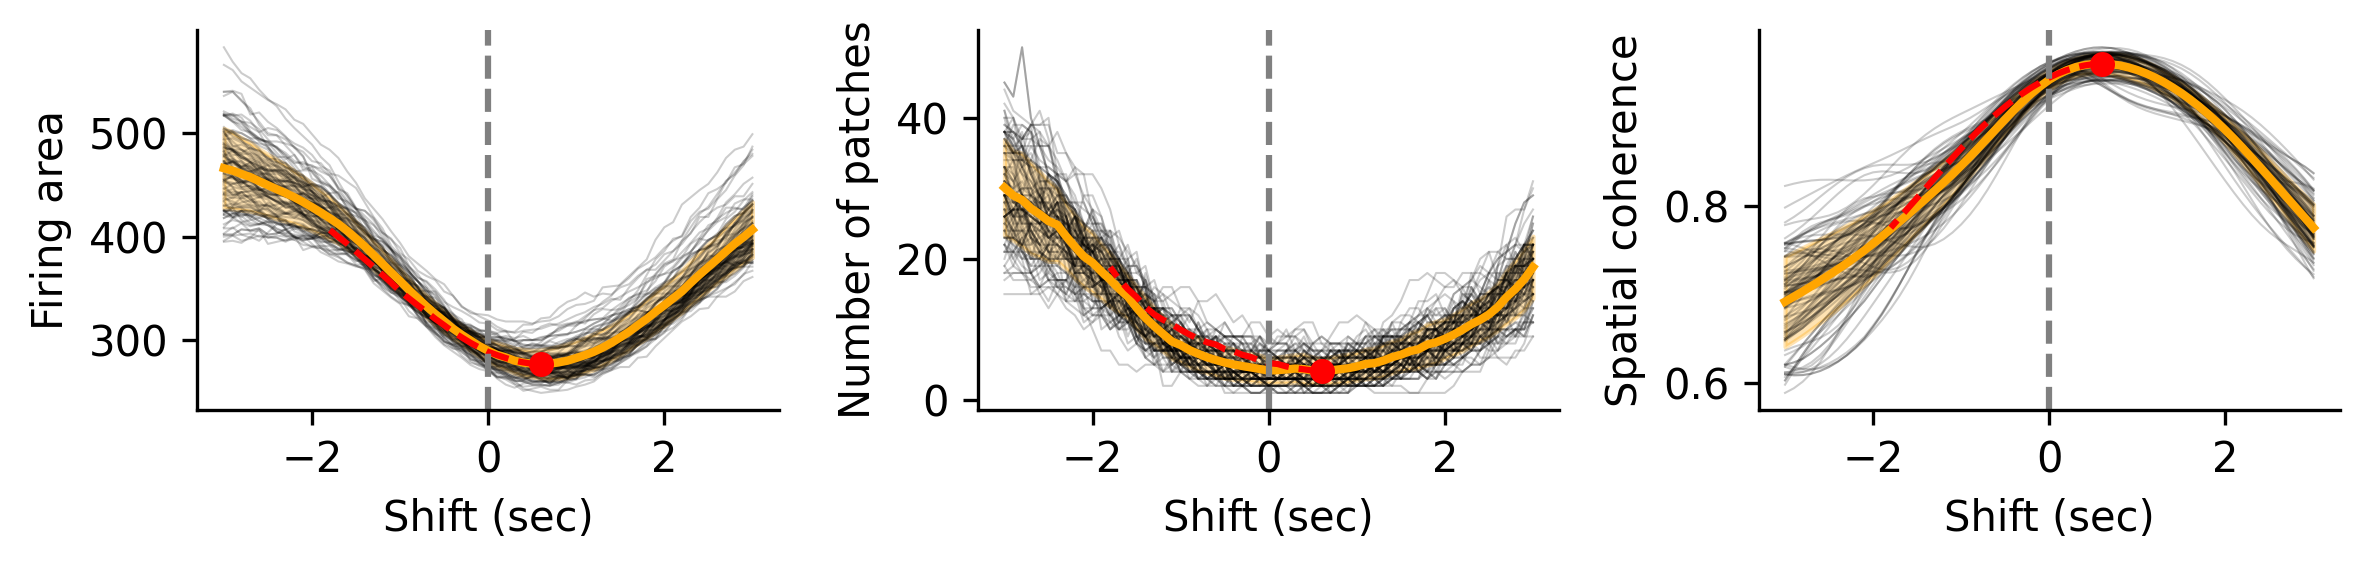

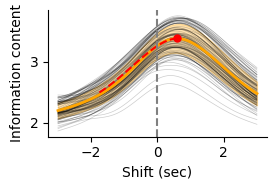

In [23]:
#Plot the shift firing area for all cells
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8, 2), dpi=300)


#1, plot the firing area
for i in range(Nsamples):
    ax1.plot(shifts/10, Shift_Firing_Area_4_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the firing area
Shift_Firing_Area_4_all_cells = np.asarray(Shift_Firing_Area_4_all_cells)
mean = np.mean(Shift_Firing_Area_4_all_cells, axis=0)
std = np.std(Shift_Firing_Area_4_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax1.plot(shifts/10, mean, linewidth=2, color='orange')
ax1.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the minima of the firing area and reflect the right half to the left as a red dashed line
minima = np.argmin(mean)
#mark the minima as a red point
ax1.plot(shifts[minima]/10, mean[minima], color='red', marker='o', markersize=5)
#mirror the right half from the minima until the end
x = shifts[minima:]
#mirror x values with respect to shifts[minima]
x = 2*shifts[minima] - x
y = mean[minima:]
#mirror the right half from the minima until the end to the left
ax1.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax1.axvline(x=0, color='grey', linestyle='--')

ax1.set_xlabel('Shift (sec)')
ax1.set_ylabel('Firing area')

#spines are removed
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#2, plot the patchiness
for i in range(Nsamples):
    ax2.plot(shifts/10, Patchiness_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)

#get the mean and std of the patchiness
Patchiness_for_all_cells = np.asarray(Patchiness_for_all_cells)
mean = np.mean(Patchiness_for_all_cells, axis=0)
std = np.std(Patchiness_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax2.plot(shifts/10, mean, linewidth=2, color='orange')
ax2.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the minima of the patchiness and reflect the right half to the left as a red dashed line
minima = np.argmin(mean)
#mark the minima as a red point
ax2.plot(shifts[minima]/10, mean[minima], color='red', marker='o', markersize=5)
#mirror the right half from the minima until the end
x = shifts[minima:]
#mirror x values with respect to shifts[minima]
x = 2*shifts[minima] - x

y = mean[minima:]
#mirror the right half from the minima until the end to the left
ax2.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax2.axvline(x=0, color='grey', linestyle='--')

ax2.set_xlabel('Shift (sec)')
ax2.set_ylabel('Number of patches')

#spines are removed
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#3, plot the spatial coherence
for i in range(Nsamples):
    ax3.plot(shifts/10, Spatial_Coherence_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the spatial coherence
Spatial_Coherence_for_all_cells = np.asarray(Spatial_Coherence_for_all_cells)
mean = np.mean(Spatial_Coherence_for_all_cells, axis=0)
std = np.std(Spatial_Coherence_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax3.plot(shifts/10, mean, linewidth=2, color='orange')
ax3.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the max of the firing area and reflect the right half to the left as a red dashed line
maxima = np.argmax(mean)
#mark the maxima as a red point
ax3.plot(shifts[maxima]/10, mean[maxima], color='red', marker='o', markersize=5)
#mirror the right half from the maxima until the end
x = shifts[maxima:]
#mirror x values with respect to shifts[maxima]
x = 2*shifts[maxima] - x
y = mean[maxima:]
#mirror the right half from the maxima until the end to the left
ax3.plot(x/10, y, color='red', linestyle='--')
    
#mark x=0 as a black dashed line
ax3.axvline(x=0, color='grey', linestyle='--')

ax3.set_xlabel('Shift (sec)')
ax3.set_ylabel('Spatial coherence')

#spines are removed
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/shift_analysis_4_all_cells.png', dpi=300)

############################################################################################################
#plot the spatial information content for all cells in a new figure
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
#plot the spatial information content as a function of the shift
for i in range(Nsamples):
    ax.plot(shifts/10, Spatial_Information_Content_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the spatial information content
Spatial_Information_Content_for_all_cells = np.asarray(Spatial_Information_Content_for_all_cells)
mean = np.mean(Spatial_Information_Content_for_all_cells, axis=0)
std = np.std(Spatial_Information_Content_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax.plot(shifts/10, mean, linewidth=2, color='orange')
ax.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the max of the firing area and reflect the right half to the left as a red dashed line
maxima = np.argmax(mean)
#mark the maxima as a red point
ax.plot(shifts[maxima]/10, mean[maxima], color='red', marker='o', markersize=5)
#mirror the right half from the maxima until the end
x = shifts[maxima:]

#mirror x values with respect to shifts[maxima]
x = 2*shifts[maxima] - x
y = mean[maxima:]
#mirror the right half from the maxima until the end to the left
ax.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax.axvline(x=0, color='grey', linestyle='--')

ax.set_xlabel('Shift (sec)')
ax.set_ylabel('Information content')

#spines are removed
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/spatial_information_content_4_all_cells.png', dpi=300)